# 白石のモジュール検出の結果を使用するエラーの場合

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# モジュールのインポート
import os
import json
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sys
import pickle
# import dataloader

In [3]:
# 自作モジュール
sys.path.append("../src")
import module_extraction
from module_extraction import Filters, Modules
import utils

分析対象の指定

In [4]:
# 白石のモジュール検出の結果を指定する
# -- 元の個別画像 --
# input_img_path = '../images/ortho/白石のモジュール検出結果/module_issue/0106_half_image.png'
input_img_path = '../images/ortho/白石のモジュール検出結果/module_issue/0081_half_image.png'
# -- マスク画像 --
# input_img_mask_path = '../images/ortho/白石のモジュール検出結果/module_issue/0106_half_pred.png'
input_img_mask_path = '../images/ortho/白石のモジュール検出結果/module_issue/0081_half_pred.png'

In [5]:
# 出力先フォルダの作成
output_dir_path = "../outputs/" + input_img_path.split("/")[-2] + "/" + input_img_path.split("/")[-1][:-4]
print(output_dir_path)
os.makedirs(output_dir_path,exist_ok=True)

../outputs/module_issue/0081_half_image


フィルタの適用

In [6]:
filters = Filters()

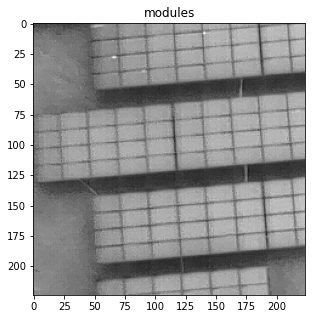

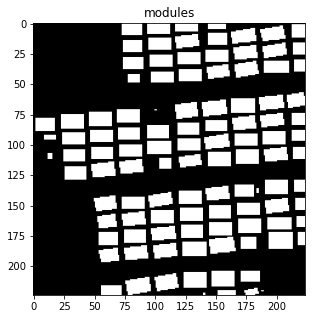

In [7]:
# 元画像
img_org = cv2.imread(input_img_path, 0)
utils.show_img({"modules":img_org},cmap="gray", vmax=255, figsize=(5,5))
# マスク画像
img_con = cv2.imread(input_img_mask_path, 0)
utils.show_img({"modules":img_con},cmap="gray", vmax=255, figsize=(5,5))

In [8]:
# マスク画像のマトリックスを指定する
# with open('../images/ortho/白石のモジュール検出結果/module_issue/0106_module_contours.pkl', 'rb') as pkl:
#     candidate_module_contours = pickle.load(pkl)
#     print(candidate_module_contours)
with open('../images/ortho/白石のモジュール検出結果/module_issue/0081_module_contours.pkl', 'rb') as pkl:
    candidate_module_contours = pickle.load(pkl)
    print(candidate_module_contours)

[array([[140, 222],
       [141, 222],
       [141, 223],
       [140, 223]]), array([[189, 220],
       [189, 220],
       [188, 220],
       [188, 220]]), array([[152, 220],
       [166, 220],
       [166, 223],
       [152, 223]]), array([[174, 220],
       [184, 218],
       [185, 222],
       [175, 224]]), array([[ 56, 216],
       [ 72, 216],
       [ 72, 223],
       [ 56, 223]]), array([[ 76, 212],
       [ 95, 209],
       [ 96, 220],
       [ 78, 223]]), array([[100, 209],
       [117, 206],
       [119, 217],
       [102, 220]]), array([[124, 205],
       [142, 205],
       [142, 217],
       [124, 217]]), array([[171, 204],
       [186, 204],
       [186, 212],
       [171, 212]]), array([[147, 204],
       [165, 204],
       [165, 216],
       [147, 216]]), array([[ 54, 187],
       [ 69, 185],
       [ 70, 195],
       [ 56, 196]]), array([[ 75, 185],
       [ 93, 183],
       [ 94, 193],
       [ 76, 194]]), array([[ 99, 183],
       [117, 181],
       [118, 191],
      

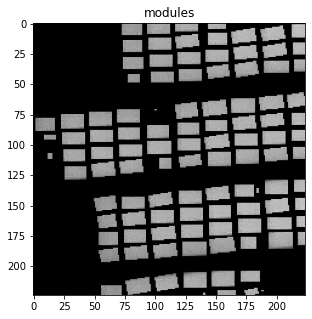

In [9]:
# モジュール抽出画像
img_mask = cv2.bitwise_and(img_org, img_con)
utils.show_img({"modules":img_mask},cmap="gray",figsize=(5,5))

In [10]:
# 画像の出力
img_write = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index_no_dbscan.png',img_write)

True

モジュール候補のクラスタリング

In [11]:
# クラスタのラベルを取得
modules = Modules(candidate_module_contours)
module_labels = modules.get_dbscan_labels(candidate_module_contours, eps=1.25)
print(module_labels)

[ 0  1  0  1 -1 -1 -1  0  1  0  3  4  5  6  7  2  2  2  3  4  5  6  7  2
  2  2  3  4  5  6  7  2  2  2  4  3  5  6  2  7  2  2  2  8 10 11 12 13
  8 14 15  8  9  9 10 11 12 13 14  8 15  8  9  9 10 11 12 13 14  8 15  9
  8  9 10 12 11 13 14 15  9  9 17 18 19 20 21 16 16 17 18 19 20 21 16 16
 17 18 19 20 21 16 16 20 19 18 17]


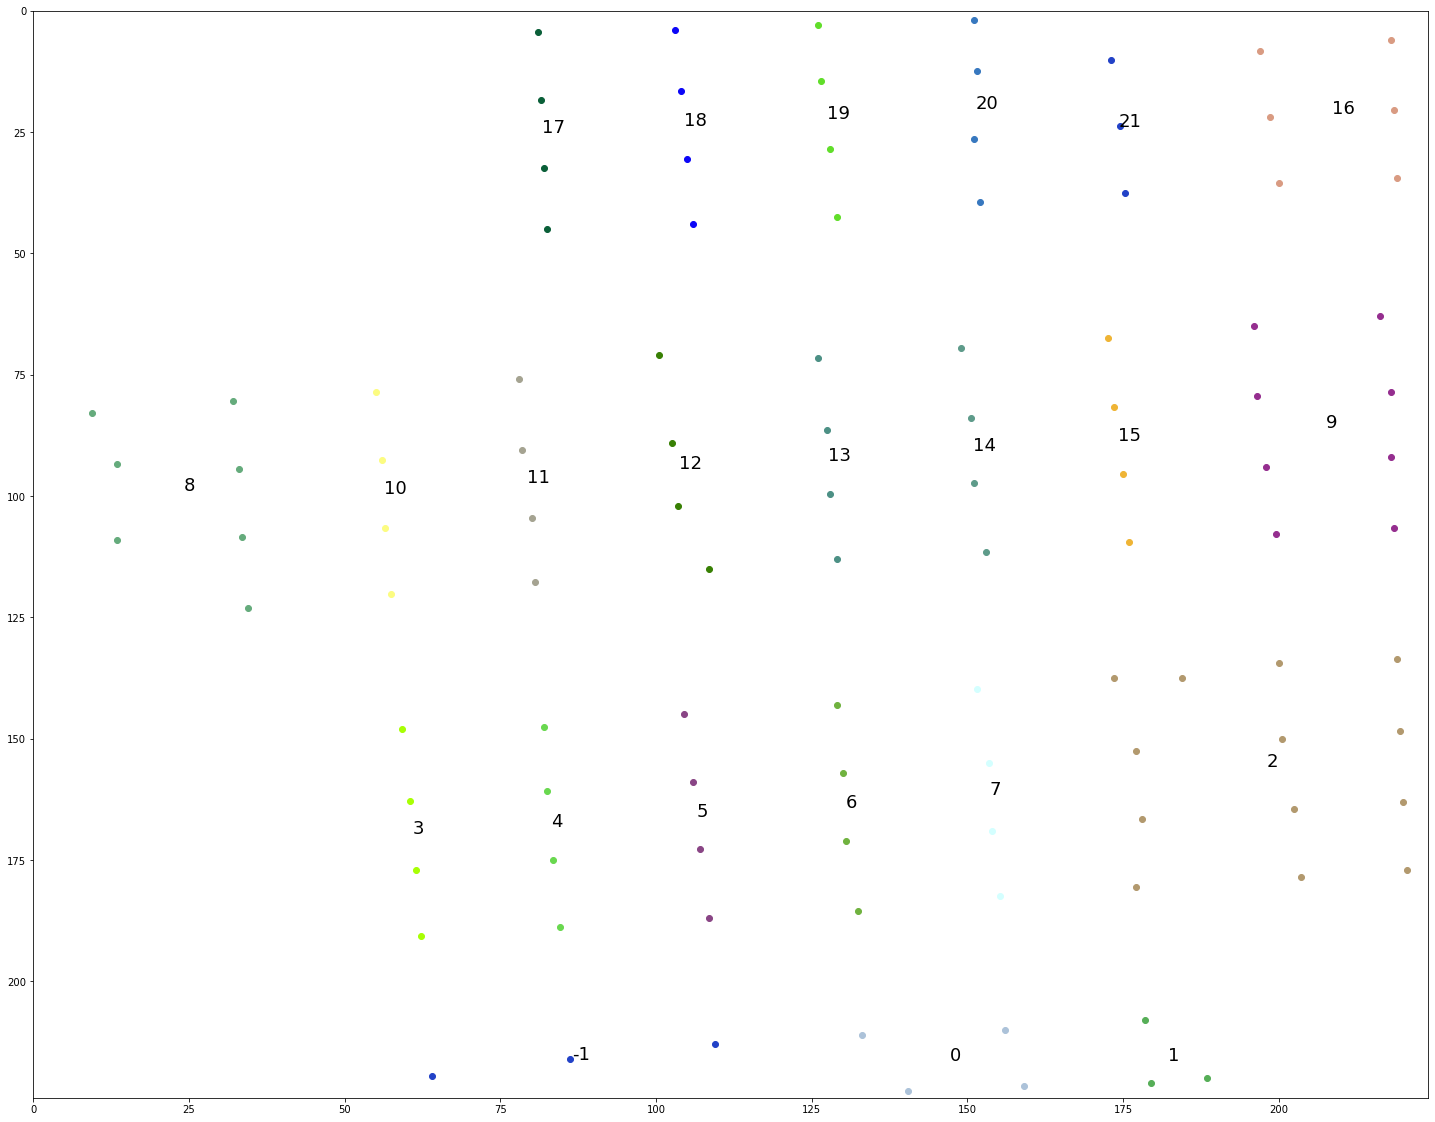

In [12]:
module_extraction.plot_module_map_with_labels(img_org, candidate_module_contours, module_labels)

サイズが大きいクラスタのみを残す

In [13]:
from collections import Counter
counter = Counter(module_labels)

In [14]:
counter.most_common

<bound method Counter.most_common of Counter({2: 13, 9: 8, 8: 7, 16: 6, 0: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 10: 4, 11: 4, 12: 4, 13: 4, 14: 4, 15: 4, 17: 4, 18: 4, 19: 4, 20: 4, 1: 3, -1: 3, 21: 3})>

In [15]:
n_threshold = 1
group_labels = np.array([i for (i, count) in counter.most_common() if i>0 and count>n_threshold])
group_flags = [label in group_labels for label in module_labels]

In [16]:
# クラスタのラベルを取得
module_contours = np.array(candidate_module_contours)[group_flags]
modules = Modules(module_contours) # 真のモジュール情報に更新
module_labels = modules.get_dbscan_labels(module_contours, eps=1.25)

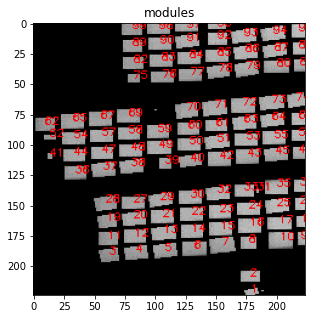

In [17]:
# モジュール抽出画像
img_con = modules.get_img_contours(img_org, index=False)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)
utils.show_img({"modules":img_mask_index},cmap="gray",figsize=(5,5))

In [18]:
# 画像の出力
img_write = cv2.cvtColor(img_mask_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index.png',img_write)

True

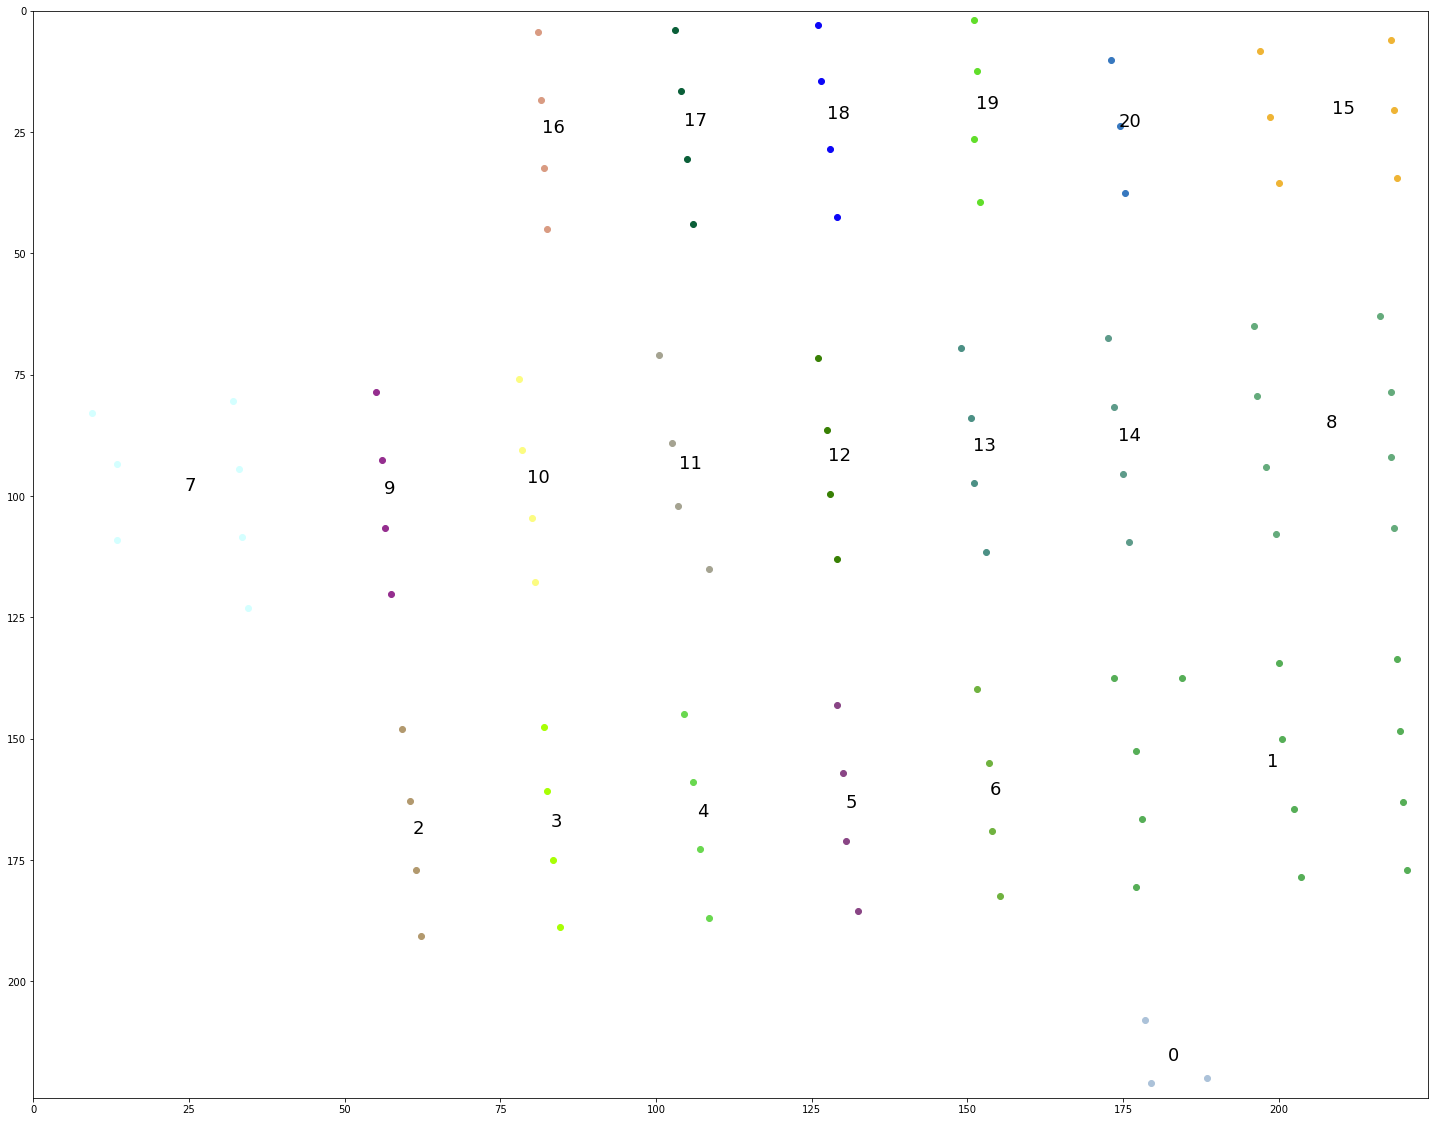

In [19]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, module_labels)

In [20]:
desired_cluster_size = 50

In [21]:
splitted_module_labels = module_extraction.split_module_labels(
    module_contours, module_labels, desired_cluster_size)

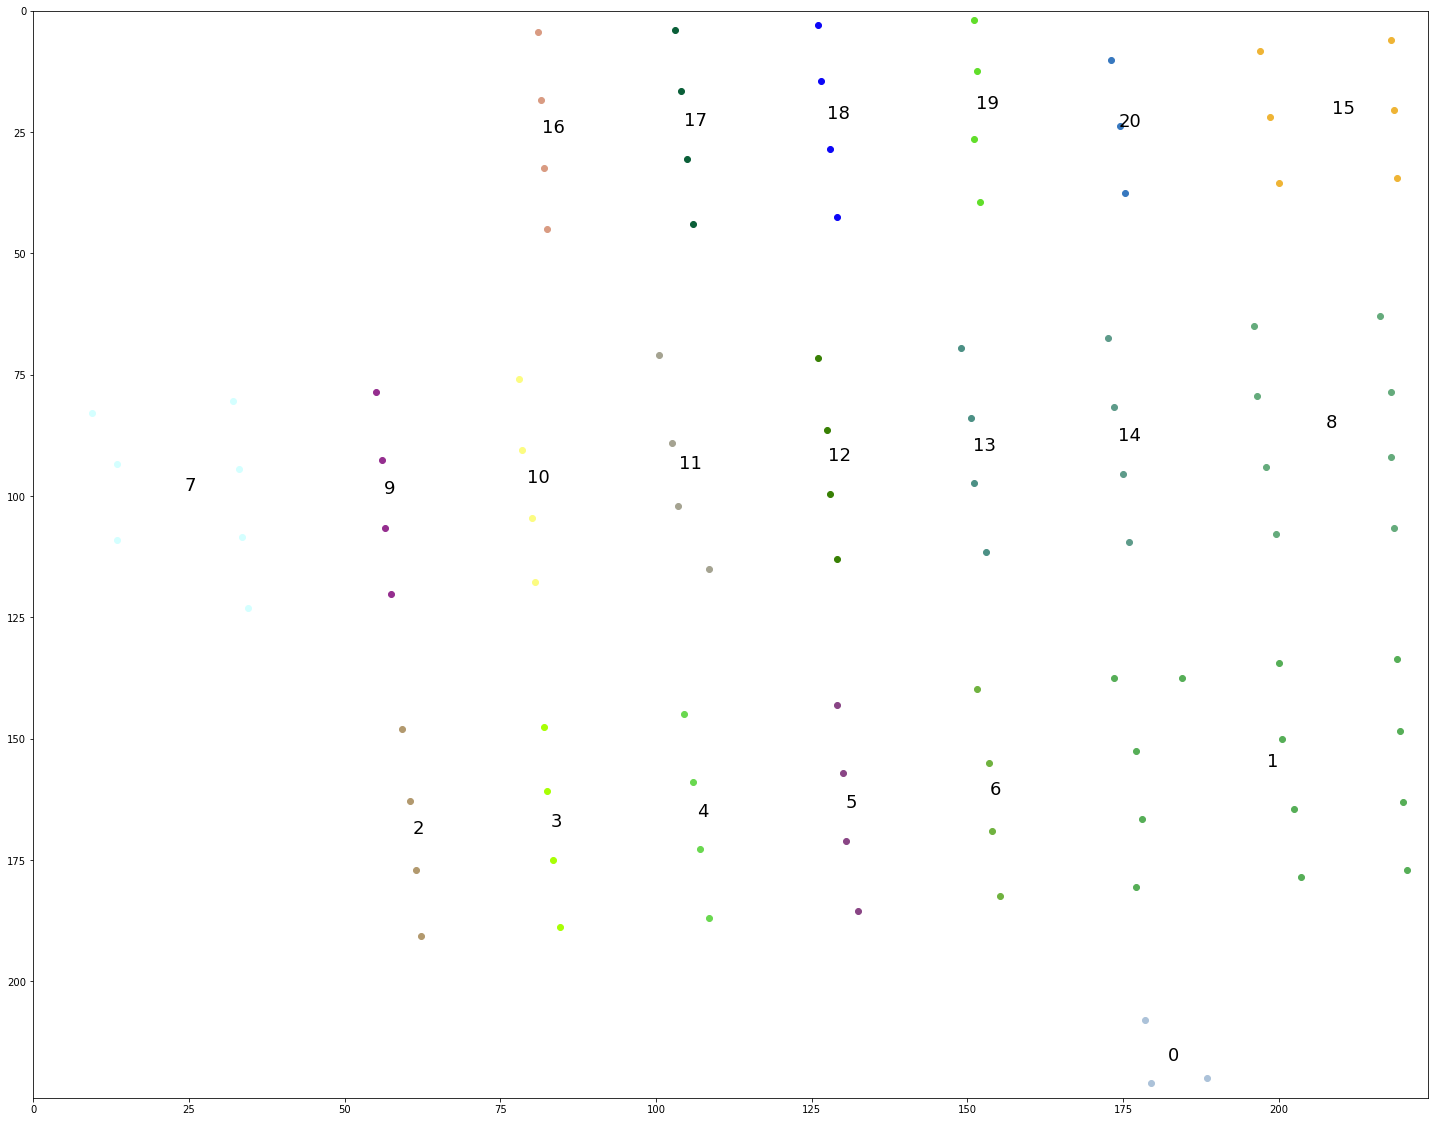

In [22]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, splitted_module_labels)

In [23]:
# モジュール画像の切り出し＆保存
modules.extract_modules(img_org, output_dir_path)

error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:2595: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'warpAffine'


In [24]:
# モジュール輪郭情報とラベルの保存
with open(output_dir_path+'/module_contours.pkl', 'wb') as pkl:
    pickle.dump(module_contours, pkl)
with open(output_dir_path+'/module_labels.pkl', 'wb') as pkl:
    pickle.dump(module_labels, pkl)    
with open(output_dir_path+'/module_labels_split.pkl', 'wb') as pkl:
    pickle.dump(splitted_module_labels, pkl) 